## **Assignment 5: Implementation of cost sesitive logisitcs regression.**

<font size='4'>**Submitted by:**</br>
1. Anilava Kundu **CS20MTECH01002**
2. Kuldeep Gautam **CS20MTECH01004**
3. Vishal Singh Yadav **CS20MTECH01001**

In [1]:
import numpy as np
import pandas as pd
import datetime
import random
import joblib
from scipy.stats import skew, norm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from collections import Counter

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 2000)

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.simplefilter(action="ignore")

In [2]:
fraud_data = pd.read_csv("costsensitivedata.csv")
fraud_data.columns

Index(['Status', 'NotCount', 'YesCount', 'ATPM', 'PFD', 'PFG', 'SFD', 'SFG',
       'WP', 'WS', 'FNC'],
      dtype='object')

In [3]:
fraud_data.rename(
    columns={
        "NotCount": "Not_filed_in_time",
        "YesCount": "Filed_in_time",
        "ATPM": "Average_tax_pm",
        "PFD": "purchas_frm_fraud",
        "PFG": "purchas_frm_genuine",
        "SFD": "sales_to_fraud",
        "SFG": "sales_to_genuin",
        "WP": "Way_bill_purchas",
        "WS": "way_bill_sale",
        "FNC": "False_Neg_Cost",
    },
    inplace=True,
)

In [4]:
fraud_data.describe()

,Status,Not_filed_in_time,Filed_in_time,Average_tax_pm,purchas_frm_fraud,purchas_frm_genuine,sales_to_fraud,sales_to_genuin,Way_bill_purchas,way_bill_sale,False_Neg_Cost
count,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,1.476360e+05
mean,0.298586,7.722107,15.220908,0.253245,0.027062,0.050789,0.021648,0.071709,0.271927,0.493587,5.334049e+02
std,0.457639,7.574278,7.596921,0.366280,0.335509,0.373370,0.298285,1.135755,2.432425,0.763389,8.774011e+03
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,2.000000,10.000000,0.001084,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.820820e-01
50%,0.000000,4.000000,19.000000,0.033354,0.000000,0.000000,0.000000,0.000000,0.000000,0.097875,1.183562e+01
75%,1.000000,13.000000,21.000000,0.394372,0.000000,0.000000,0.000000,0.000000,0.061840,0.880929,1.069840e+02
max,1.000000,23.000000,22.000000,1.000000,79.837480,51.944780,61.556900,209.021870,399.606420,5.000000,1.703186e+06


In [5]:
fraud_data.head()

,Status,Not_filed_in_time,Filed_in_time,Average_tax_pm,purchas_frm_fraud,purchas_frm_genuine,sales_to_fraud,sales_to_genuin,Way_bill_purchas,way_bill_sale,False_Neg_Cost
0,0,2,21,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0
1,1,23,0,0.0,0.044,0.0,0.0,0.0,0.306179,0.0,0.0
2,0,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0
3,1,5,18,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0


In [6]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147636 entries, 0 to 147635
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Status               147636 non-null  int64  
 1   Not_filed_in_time    147636 non-null  int64  
 2   Filed_in_time        147636 non-null  int64  
 3   Average_tax_pm       147636 non-null  float64
 4   purchas_frm_fraud    147636 non-null  float64
 5   purchas_frm_genuine  147636 non-null  float64
 6   sales_to_fraud       147636 non-null  float64
 7   sales_to_genuin      147636 non-null  float64
 8   Way_bill_purchas     147636 non-null  float64
 9   way_bill_sale        147636 non-null  float64
 10  False_Neg_Cost       147636 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 12.4 MB


In [7]:
pd.DataFrame(fraud_data.isnull().sum() / len(fraud_data) * 100).reset_index().rename(
    columns={"index": "Features", 0: "Missing %"}
)

,Features,Missing %
0,Status,0.0
1,Not_filed_in_time,0.0
2,Filed_in_time,0.0
3,Average_tax_pm,0.0
4,purchas_frm_fraud,0.0
5,purchas_frm_genuine,0.0
6,sales_to_fraud,0.0
7,sales_to_genuin,0.0
8,Way_bill_purchas,0.0
9,way_bill_sale,0.0


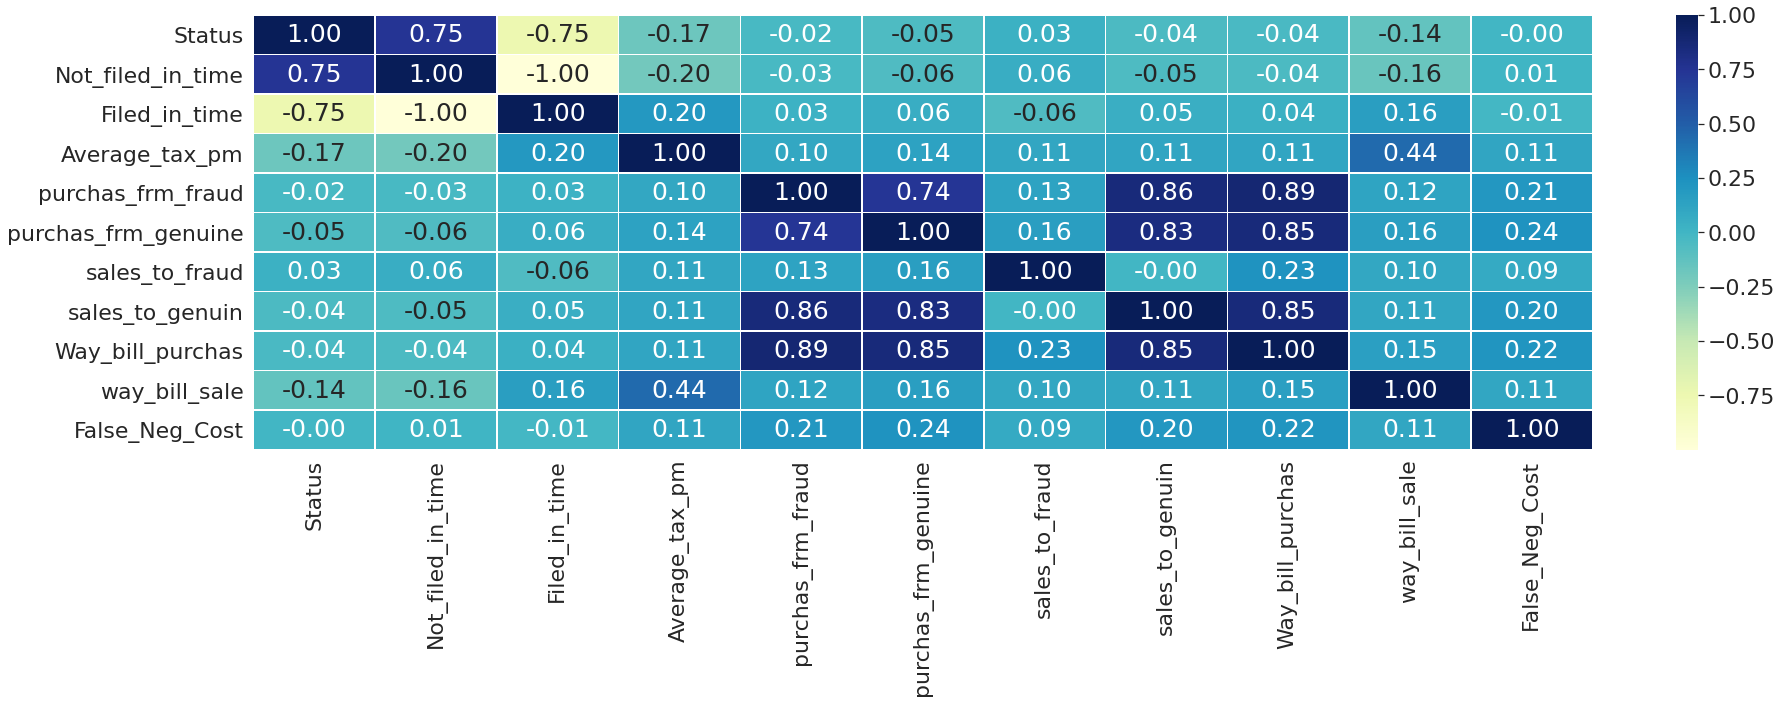

In [8]:
correlation_train = fraud_data.corr("pearson")
sns.set(font_scale=2)
fig = plt.figure(figsize=(30, 8))
ax = sns.heatmap(
    correlation_train,
    annot=True,
    annot_kws={"size": 25},
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
)
fig.show()

# Observation

* `Not_Filed_in_time` is highly correlated with `Status` which make sense.
* `purchas_frm_genuine` is highly correlated with `purchas_frm_fraud`, `saled_to_genuin` and `Way_bill_purchas`.
* `purchas_frm_fraud` is highly correlated with `purchas_frm_genuine`, `saled_to_genuin` and `Way_bill_purchas`.
* `saled_to_genuin` is highly correlated with `Way_bill_purchas`.
* `Filed_in_time` is highly -ve correlated with `Status` which also make sense. 

In [9]:
fraud_data.columns

Index(['Status', 'Not_filed_in_time', 'Filed_in_time', 'Average_tax_pm',
       'purchas_frm_fraud', 'purchas_frm_genuine', 'sales_to_fraud',
       'sales_to_genuin', 'Way_bill_purchas', 'way_bill_sale',
       'False_Neg_Cost'],
      dtype='object')

### **Plotting the distribution of data points for numerical columns.**

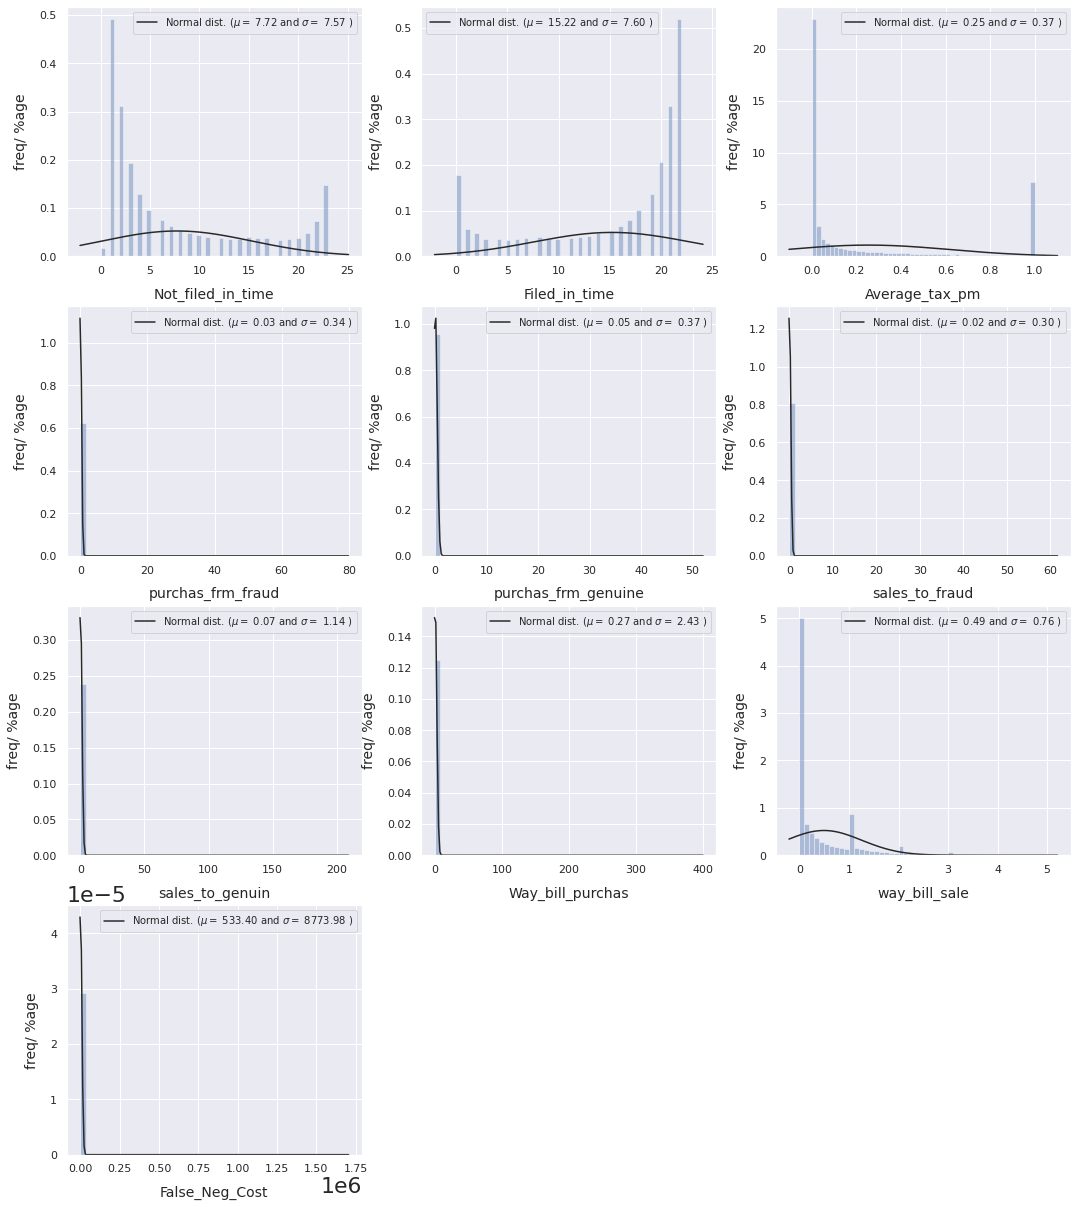

In [10]:
# Setting basic params for the figure.
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(18, 12))
plt.subplots_adjust(top=1.8)
sns.color_palette("husl", 8)
numerical_features = fraud_data.columns.tolist()[1:]

for index, feature in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features) // 2, 3, index)
    sns.distplot(fraud_data[feature], fit=norm, kde=False)

    # Fitting the gaussian distribution on the data points
    if fraud_data[feature].isnull().sum() < 1:
        (mu, sigma) = norm.fit(fraud_data[feature])

    else:
        # Handling null values for norm API.
        (mu, sigma) = norm.fit(fraud_data[feature].dropna())

    plt.legend(
        ["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)],
        loc="best",
        prop={"size": 10},
    )
    plt.xlabel(f"{feature}", size=14, labelpad=11.5)
    plt.ylabel("freq/ %age", size=14, labelpad=11.5)
    plt.tick_params(axis="x", labelsize=11)
    plt.tick_params(axis="y", labelsize=11)

plt.show()

### **Exploring the features for better understanding.isha**

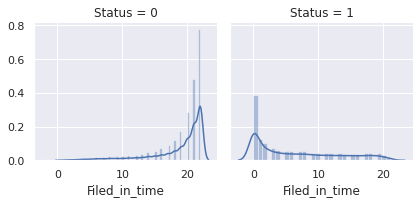

In [11]:
sns.set(rc={"figure.figsize": (20, 15)})
g = sns.FacetGrid(fraud_data, col="Status")
g = g.map(sns.distplot, "Filed_in_time")

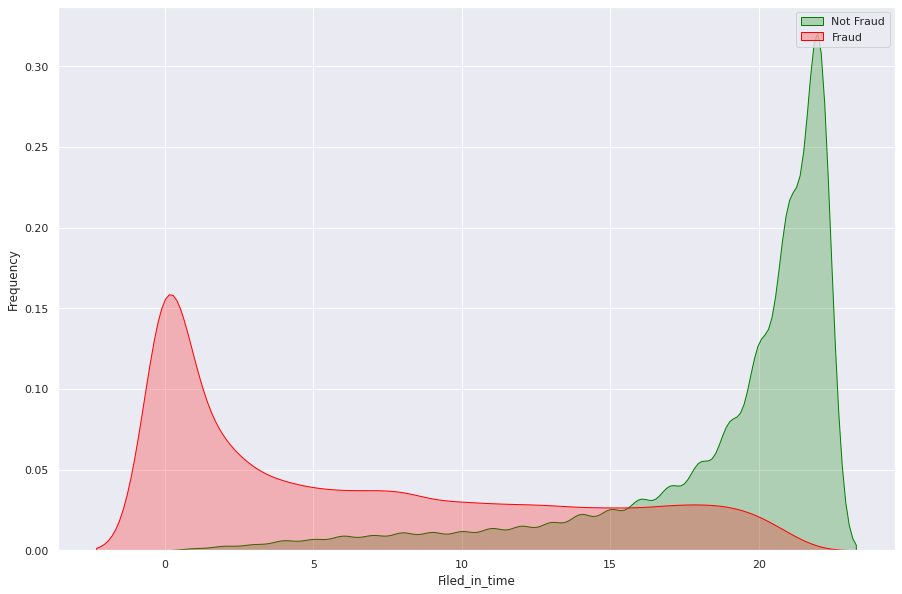

In [12]:
sns.set(rc={"figure.figsize": (15, 10)})
g = sns.kdeplot(
    fraud_data["Filed_in_time"][
        (fraud_data["Status"] == 0) & (fraud_data["Filed_in_time"].notnull())
    ],
    color="green",
    shade=True,
)
g = sns.kdeplot(
    fraud_data["Filed_in_time"][
        (fraud_data["Status"] == 1) & (fraud_data["Filed_in_time"].notnull())
    ],
    ax=g,
    color="red",
    shade=True,
)
g.set_xlabel("Filed_in_time")
g.set_ylabel("Frequency")
g = g.legend(["Not Fraud", "Fraud"])

# Observation

* Frauds are peaked around `zero` `Filed_in_time` . 
* Not Frauds are peaked around `>20` `Filed_in_time`

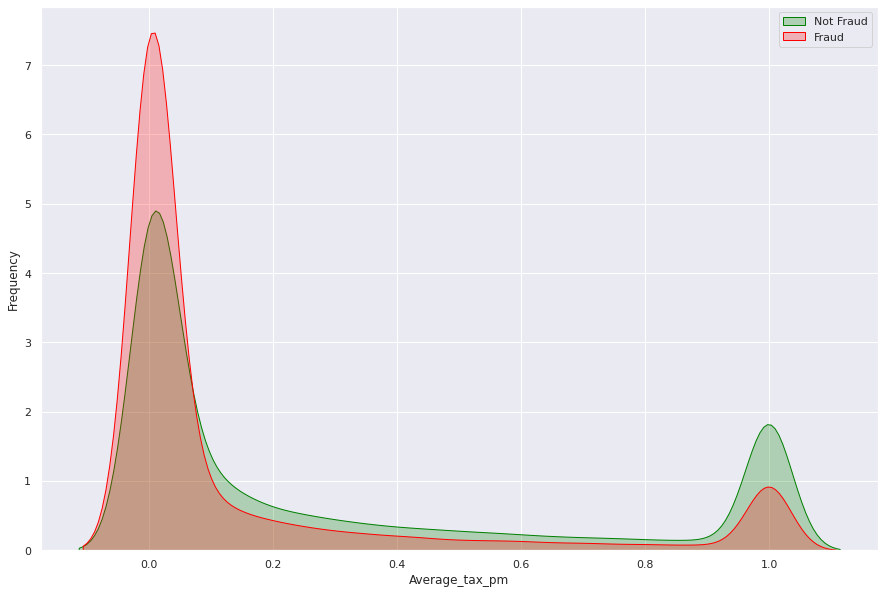

In [13]:
g = sns.kdeplot(
    fraud_data["Average_tax_pm"][
        (fraud_data["Status"] == 0) & (fraud_data["Average_tax_pm"].notnull())
    ],
    color="green",
    shade=True,
)
g = sns.kdeplot(
    fraud_data["Average_tax_pm"][
        (fraud_data["Status"] == 1) & (fraud_data["Average_tax_pm"].notnull())
    ],
    ax=g,
    color="red",
    shade=True,
)
g.set_xlabel("Average_tax_pm")
g.set_ylabel("Frequency")
g = g.legend(["Not Fraud", "Fraud"])

# Observation

*  Frauds are peaked around `zero` `Average_tax_pm` . 
*  Not Frauds are peaked around `1` `Average_tax_pm`

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    fraud_data.iloc[:, 1:], fraud_data.iloc[:, :1], test_size=0.2, random_state=0
)
X_train.shape, y_train.shape

((118108, 10), (118108, 1))

In [15]:
# fraud_data["True_Negativ_Cost"] = 0
# fraud_data["True_Positive_Cost"] = 150
# fraud_data["False_Positive_Cost"] = 150

In [16]:
cost_matrix_train = np.zeros((len(y_train), 4))
cost_matrix_train[:, 0] = 150
cost_matrix_train[:, 1] = X_train["False_Neg_Cost"]
cost_matrix_train[:, 2] = 150

cost_matrix_test = np.zeros((len(y_test), 4))
cost_matrix_test[:, 0] = 5
cost_matrix_test[:, 1] = X_test["False_Neg_Cost"]
cost_matrix_test[:, 2] = 150

In [17]:
from costcla.metrics import cost_loss, savings_score
from costcla.models import CostSensitiveLogisticRegression

cslr = CostSensitiveLogisticRegression()
cslr.fit(np.array(X_train), np.array(y_train), cost_matrix_train)
predictions = cslr.predict(X_test)
print(cost_loss(y_test, predictions, cost_matrix_test))

1072217.414756
